# EDI Index Calculation Strategy



| **Calculation Step**                            | **Description**                                                                                | **Notes**                                                                     |
| ----------------------------------------------- | ---------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------- |
| **Step 1: Apply Weighted High-Quality Metrics** | Assign heavier weights to well-reported, reliable, high-confidence variables.                  | Improves robustness and reduces distortion from sparse or low-quality inputs. |
| **Step 2: Group Variables by EDI Principles**   | Organize indicators according to Equality, Diversity, and Inclusion principles.                  | Creates conceptual clarity and consistency.                                   |
| **Step 3: Values Normalisation**                | Rescale variables to a common range (e.g., 0–1, min–max, or z-scores) to ensure comparability. | Prevents metrics with large numeric ranges from dominating the index.         |
| **Step 4: Compute Domain-Level Sub-Scores**     | Generate composite scores for domains where data availability is sufficient.                   | Enables nuanced comparisons across EDI dimensions.                            |
| **Step 5: Add Transparency Index**              | Include a score based on data completeness, clarity, and reporting quality.                    | Rewards transparent and consistent data disclosure.                           |
| **Step 6: General EDI Index**                   | Combine domain sub-scores and the transparency index into a single final EDI score.            | Provides an overall comparable EDI performance rating.                        |



In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('Project_csv/filled_dataset.csv')

### 1. Apply Weighted High-Quality Metrics 

###### Assign heavier weights to well-reported, reliable, high-confidence variables.

Formula: Completeness Weight = (100 - % Missing) / 100

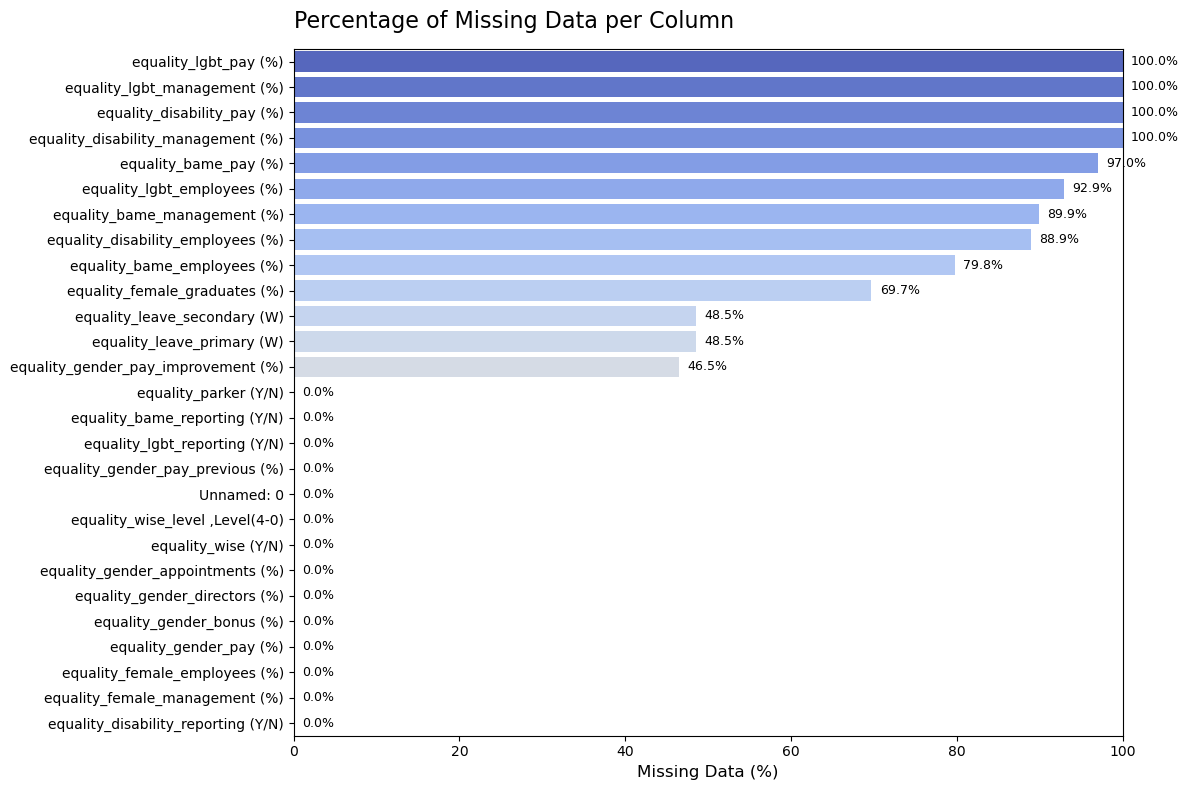

In [41]:
# Missing data visualization

# Calculate % missing per column
missing_percent = data.isna().mean() * 100
missing_percent = missing_percent.sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    x=missing_percent.values,
    y=missing_percent.index,
    hue=missing_percent.index,          
    palette='coolwarm',
    legend=False                        
)

# Style
plt.title('Percentage of Missing Data per Column', fontsize=16, loc='left', pad=15)
plt.xlabel('Missing Data (%)', fontsize=12)
plt.ylabel('')
plt.xlim(0, 100)

# Add % labels at the end of each bar
for i, v in enumerate(missing_percent.values):
    plt.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [43]:
missing_percent = data.isna().mean() * 100

# Completeness weight
completeness_weight = (100 - missing_percent) / 100

# Build final tidy dataframe
completeness_weight = (
    completeness_weight
    .rename("weight")            
    .rename_axis("column")         
    .reset_index()                 # convert to dataframe
    .reset_index(drop=True)
)

completeness_weight.head(2)


,column,weight
0,Unnamed: 0,1.00000
1,equality_female_graduates (%),0.30303


### 2. Group Variables by EDI 

###### Principles	Organize indicators according to Equality, Diversity, and Inclusion principles.

In [44]:
# EQUALITY (Fair treatment, pay, and opportunities)

equality = [
"equality_gender_pay (%)",
"equality_gender_pay_previous (%)", 
"equality_gender_pay_improvement (%)",
"equality_gender_bonus (%)", 
"equality_bame_pay (%)", 
"equality_lgbt_pay (%)", 
"equality_disability_pay (%)", 
"equality_leave_primary (W)",
"equality_leave_secondary (W)"] 

# DIVERSITY (Representation across levels)

diversity = [
"equality_female_employees (%)", 
"equality_female_management (%)",
"equality_female_graduates (%)", 
"equality_gender_directors (%)", 
"equality_gender_appointments (%)", 
"equality_bame_employees (%)", 
"equality_bame_management (%)", 
"equality_lgbt_employees (%)",
"equality_lgbt_management (%)", 
"equality_disability_employees (%)", 
"equality_disability_management (%)"] 

# INCLUSION (Transparency, accountability, and commitment)

inclusion = [
"equality_bame_reporting (Y/N)", 
"equality_lgbt_reporting (Y/N)", 
"equality_disability_reporting (Y/N)",
"equality_wise (Y/N)", 
"equality_wise_level (Level 4-0)", 
"equality_parker (Y/N)"] 


In [45]:
# Build a Pandas Series mapping column → flag
edi_map = pd.concat([
    pd.Series("E", index=equality),
    pd.Series("D", index=diversity),
    pd.Series("I", index=inclusion)
])

# Keep only columns present in your dataset
edi_map = edi_map[edi_map.index.isin(data.columns)]

# Convert to final dataframe
edi_flags = edi_map.rename_axis("column").reset_index(name="edi_flag")


In [46]:
edi_flags.head(2) 

,column,edi_flag
0,equality_gender_pay (%),E
1,equality_gender_pay_previous (%),E


### 3. Values Normalisation

###### Rescale variables to a common range to ensure comparability.

###### 1. Percentage Metrics 
"Higher is Better" normalisation , because all metrics is higher is better. 

Formula: Normalized score = Value / 100

In [47]:
# Select all columns that contain "(%)"
percent_cols = data.filter(like="(%)").columns

# Apply normalization: Value / 100
data[percent_cols] = data[percent_cols] / 100

###### 2. Binary Metrics (Y/N)

Don't need to normalise as already has values 0 and 1

###### 3. Level Metrics (0-4)

Normalized score = Actual_level / Max_level   
Normalized score = Level / 4

In [48]:
level_cols = data.filter(like="(4-0)").columns

# Apply normalization: value / 4
data[level_cols] = data[level_cols] / 4

###### 4. Leave Policies (Weeks)

Formula: Normalized score = Weeks / Max_weeks_in_dataset 

In [49]:
# Select all columns that contain "(W)"
week_cols = data.filter(like="(W)").columns

# Compute max weeks per column
max_weeks = data[week_cols].max()

# Apply normalization: Weeks / Max_weeks_in_dataset
data[week_cols] = data[week_cols].div(max_weeks)


### 4. Compute Domain-Level Sub-Scores

###### Generate composite scores for domains where data availability is sufficient.

Formula: Domain Score = Σ(Normalized_Value × Weight) / Σ(Norm_max)


In [50]:
# Multiply Normalised_Value  with Weight

weight_series = completeness_weight.set_index("column")["weight"]

data_weighted = data.mul(weight_series, axis=1)

In [51]:
# Create 3 sub-group EDI

data_weighted = data_weighted.rename(columns={"Unnamed: 0": "Company_id"})

In [52]:
# Prepare sub-dataframes for Sub-Scores calculation

# Build mapping (column → E/D/I)
edi_map = edi_flags.set_index("column")["edi_flag"]

# Map each column in the dataset to its group
column_groups = data_weighted.columns.to_series().map(edi_map)

# Split the dataframe using vectorized pandas filtering
e_df = data_weighted.loc[:, column_groups == "E"]
d_df = data_weighted.loc[:, column_groups == "D"]
i_df = data_weighted.loc[:, column_groups == "I"]


In [53]:
# Number of parameters per domain
n_e = e_df.shape[1]
n_d = d_df.shape[1]
n_i = i_df.shape[1]

# Compute domain scores
e_score = e_df.sum(axis=1, skipna=True) / n_e *100
d_score = d_df.sum(axis=1, skipna=True) / n_d * 100
i_score = i_df.sum(axis=1, skipna=True) / n_i * 100

equality_df = pd.DataFrame({"equality": e_score})
diversity_df = pd.DataFrame({"diversity": d_score})
inclusion_df = pd.DataFrame({"inclusion": i_score})

### 5. Add Transparency Index

###### Include a score based on data completeness, clarity, and reporting quality  

In [54]:
# Download original data 
data_original = pd.read_csv('Project_csv/data.csv')

# Drop all invalid data

# 1. Drop all values outside of 0-100% for numeric columns
pct_columns = [col for col in data_original.columns if '(%)' in col]
for col in pct_columns:
    data_original[col] = data_original[col].where((data_original[col] >= 0) & (data_original[col] <= 100))
    
# 2. Drop all values outside of positive week range 
w_columns = [col for col in data_original.columns if '(W)' in col]
for col in w_columns:
    data_original[col] = data_original[col].where((data_original[col] >= 0) )
    
# 3. Drop all values that is not 0,1,2,3,4
level_columns = [col for col in data_original.columns if 'Level(4-0)' in col]
for col in level_columns:
    data_original[col] = data_original[col].where(data_original[col].isin([0, 1, 2, 3, 4]))
    

In [55]:
# Calculate missing percent per row
missing_percent = data_original.isna().mean(axis=1)*100

# Build final output dataframe
transparency = pd.DataFrame({
    "company_id": data_original["Unnamed: 0"],     # or data.index if Company_id is index
    "transparency": missing_percent
})

### 6. General EDI index

###### Combine EDI and transparency 

In [56]:
# Merge all sub-indexes together

edi_index = (
    transparency
    .join(equality_df)
    .join(diversity_df)
    .join(inclusion_df)
)

In [57]:
edi_index.head(2)

,company_id,transparency,equality,diversity,inclusion
0,1,42.857143,19.142536,4.133909,20.0
1,2,46.428571,10.196440,8.004545,20.0


In [58]:
# Scale each domain to 25 points
edi_index["equality_25"] = edi_index["equality"] * 0.25
edi_index["diversity_25"] = edi_index["diversity"] * 0.25
edi_index["inclusion_25"] = edi_index["inclusion"] * 0.25

# EDI Index = sum of the 3 scores
edi_index["edi_index"] = edi_index[["equality_25", "diversity_25", "inclusion_25"]].sum(axis=1)

In [59]:
edi_index["rank"] = edi_index["edi_index"].rank(ascending=False, method="dense").astype(int)

In [60]:
edi_index

,company_id,transparency,equality,diversity,inclusion,equality_25,diversity_25,inclusion_25,edi_index,rank
0,1,42.857143,19.142536,4.133909,20.0,4.785634,1.033477,5.0,10.819111,17
1,2,46.428571,10.196440,8.004545,20.0,2.549110,2.001136,5.0,9.550246,29
2,3,25.000000,6.193603,7.545620,0.0,1.548401,1.886405,0.0,3.434806,80
3,4,53.571429,5.953464,2.586002,0.0,1.488366,0.646501,0.0,2.134867,96
4,5,60.714286,4.773179,3.425636,20.0,1.193295,0.856409,5.0,7.049704,54
...,...,...,...,...,...,...,...,...,...,...
94,95,46.428571,9.117996,7.720818,20.0,2.279499,1.930205,5.0,9.209704,32
95,96,35.714286,5.067003,5.691026,20.0,1.266751,1.422756,5.0,7.689507,50
96,97,28.571429,11.995286,7.707479,20.0,2.998822,1.926870,5.0,9.925691,26
97,98,39.285714,11.306397,9.427000,20.0,2.826599,2.356750,5.0,10.183349,23


In [61]:
# 1. Replace old columns with the _25 versions (no multiplication)
edi_index["equality"] = edi_index["equality_25"]
edi_index["diversity"] = edi_index["diversity_25"]
edi_index["inclusion"] = edi_index["inclusion_25"]

# 2. Formatting function: round to ONE decimal + "/100"
def fmt(x):
    return f"{round(x, 1)}/100"

# 3. Apply formatting
for col in ["transparency", "equality", "diversity", "inclusion", "edi_index"]:
    edi_index[col] = edi_index[col].apply(fmt)

# 4. Select columns
df_pretty = edi_index[[
    "company_id",
    "transparency",
    "equality",
    "diversity",
    "inclusion",
    "edi_index"
]]



In [62]:

df_pretty = df_pretty.merge(
    edi_index[["company_id", "rank"]],
    on="company_id",
    how="left"
)


In [63]:
df_pretty.sort_values('rank')

,company_id,transparency,equality,diversity,inclusion,edi_index,rank
39,40,39.3/100,5.1/100,1.8/100,10.0/100,16.9/100,1
11,12,28.6/100,3.9/100,1.4/100,10.0/100,15.3/100,2
35,36,50.0/100,2.7/100,1.7/100,10.0/100,14.5/100,3
70,71,35.7/100,2.6/100,1.6/100,10.0/100,14.2/100,4
8,9,42.9/100,1.5/100,2.2/100,10.0/100,13.6/100,5
...,...,...,...,...,...,...,...
26,27,57.1/100,1.2/100,1.2/100,0.0/100,2.4/100,95
3,4,53.6/100,1.5/100,0.6/100,0.0/100,2.1/100,96
81,82,46.4/100,1.0/100,0.9/100,0.0/100,1.9/100,97
31,32,46.4/100,0.7/100,1.1/100,0.0/100,1.8/100,98


In [65]:
df_pretty.to_excel('Final_ranking.xlsx')